In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding
from matplotlib import pyplot as plt


2023-04-30 20:42:35.874224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Trabajare con el dataset de dialogos de los simpsons

In [2]:
df = pd.read_csv('datasets/simpsons_dataset.csv')

df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [3]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [4]:
df['raw_character_text'].value_counts()

raw_character_text
Homer Simpson            27850
Marge Simpson            13172
Bart Simpson             12995
Lisa Simpson             10756
C. Montgomery Burns       3077
                         ...  
Basketball Player            1
Oboist                       1
Father In Burlap Sack        1
Shelbyvillians               1
Voice From Diorama           1
Name: count, Length: 6272, dtype: int64

En particular me quedare con dialogos de Homero

In [5]:
person_df = pd.DataFrame(df[df['raw_character_text'] == 'Homer Simpson']['spoken_words'])

In [6]:
print("Cantidad de documentos:", person_df.shape[0])

Cantidad de documentos: 27850


In [7]:
# largo de la secuencia, incluye seq input + word output
train_len = 5

In [8]:
# Vistazo a las primeras filas
person_df.iloc[:5,0]

51    Never thrown a party? What about that big bash...
52    Bart didn't get one vote?! Oh, this is the wor...
56                                                  Oh.
58                                                 And?
60    Hey, just because I don't care doesn't mean I ...
Name: spoken_words, dtype: object

In [9]:
# Concatenamos todos los rows en un solo valor
corpus = person_df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

In [12]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:5]

['never', 'thrown', 'a', 'party', 'what']

In [13]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 272664


In [14]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:4]

[['never', 'thrown', 'a', 'party', 'what'],
 ['thrown', 'a', 'party', 'what', 'about'],
 ['a', 'party', 'what', 'about', 'that'],
 ['party', 'what', 'about', 'that', 'big']]

In [16]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:4]

[[80, 4453, 4, 467, 18],
 [4453, 4, 467, 18, 59],
 [4, 467, 18, 59, 10],
 [467, 18, 59, 10, 159]]

In [17]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 272659


In [18]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(272659, 4)
(272659,)


In [19]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

15980

In [20]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(272659, 15980)

In [21]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

4

In [22]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

15980

In [61]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='sigmoid'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2023-04-30 22:07:19.451502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 22:07:19.454276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 22:07:19.457680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 4, 5)              79905     
                                                                 
 lstm_30 (LSTM)              (None, 4, 128)            68608     
                                                                 
 dropout_23 (Dropout)        (None, 4, 128)            0         
                                                                 
 lstm_31 (LSTM)              (None, 4, 64)             49408     
                                                                 
 dropout_24 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_32 (LSTM)              (None, 4, 128)            98816     
                                                                 
 dropout_25 (Dropout)        (None, 4, 128)           

2023-04-30 22:07:21.262296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 22:07:21.265231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 22:07:21.267227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-30 22:07:33.253250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 22:07:33.257232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 22:07:33.263705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6816/6817 [============================>.] - ETA: 0s - loss: 6.9546 - accuracy: 0.0312

2023-04-30 22:12:04.340880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-30 22:12:04.344384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-30 22:12:04.346179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6817/6817 [==============================] - 294s 42ms/step - loss: 6.9545 - accuracy: 0.0312 - val_loss: 6.9041 - val_accuracy: 0.0303
Epoch 2/50
6817/6817 [==============================] - 298s 44ms/step - loss: 6.7216 - accuracy: 0.0316 - val_loss: 6.8099 - val_accuracy: 0.0338
Epoch 3/50
6817/6817 [==============================] - 292s 43ms/step - loss: 6.5084 - accuracy: 0.0370 - val_loss: 6.6522 - val_accuracy: 0.0354
Epoch 4/50
6817/6817 [==============================] - 295s 43ms/step - loss: 6.3326 - accuracy: 0.0427 - val_loss: 6.5899 - val_accuracy: 0.0475
Epoch 5/50
6817/6817 [==============================] - 283s 41ms/step - loss: 6.2151 - accuracy: 0.0505 - val_loss: 6.5587 - val_accuracy: 0.0536
Epoch 6/50
6817/6817 [==============================] - 282s 41ms/step - loss: 6.1283 - accuracy: 0.0566 - val_loss: 6.5579 - val_accuracy: 0.0599
Epoch 7/50
6817/6817 [==============================] - 283s 41ms/step - loss: 6.0556 - accuracy: 0.0623 - val_loss: 6.5199 - val

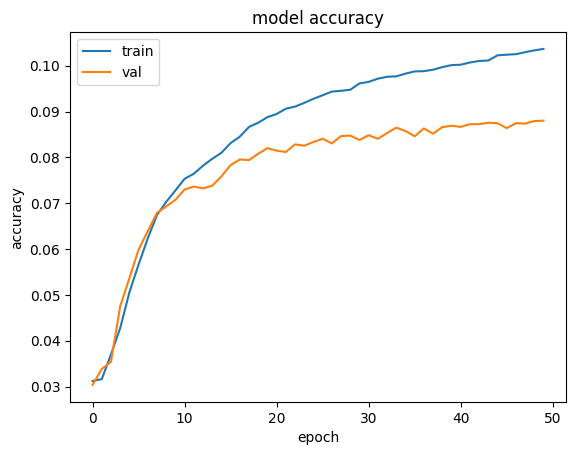

In [62]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Vamos a probar algunas oraciones

In [63]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [64]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [66]:
input_text='I want a'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 42ms/step


"I want a can't"

In [68]:
input_text='it is friday'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 24ms/step


'it is friday my'

In [69]:
input_text='I work hard for'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 29ms/step


'I work hard for i'

In [70]:
input_text='Give me a beer'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 31ms/step


'Give me a beer to'

In [71]:
input_text='What are you doing'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 34ms/step


'What are you doing a'

In [72]:
input_text='Beer is'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 21ms/step


'Beer is you'

In [81]:
input_text='please give me a'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 79ms/step


"please give me a can't"

In [83]:
input_text='what do you think about'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 42ms/step


'what do you think about i'

In [84]:
input_text='why my son is so'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 22ms/step


'why my son is so gotta'

In [85]:
input_text='why my dad is so'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 29ms/step


'why my dad is so gotta'

In [90]:
input_text='Lenny and'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 124ms/step


'Lenny and you'

In [91]:
input_text='My wife is'

generate_seq(model, tok, input_text, max_length=4, n_words=1)

1/1 [==============================] - 0s 36ms/step


'My wife is you'